# Step 4 : build a Spectral Deferred Correction type time-stepper

📜 _Now that we can approximate the_ $Q$ _matrix from our time-stepping scheme :_

$$
\begin{array}
    {c|c}
    \tau & Q \\
    \hline
    & w^\top
\end{array}
$$

_with a given_ $Q_\Delta$ _approximation, we can build a SDC-type time-stepper._

> 💡 While SDC was originally built with a collocation method, nothing prevent to use exactly the same approach with any other type of $Q$-coefficients ...

Consider (again) the _Dahlquist problem_ :

$$
\frac{du}{dt} = \lambda u, \quad t \in [0, T], \quad u(0)=u_0,
$$

with $\lambda=i$ (imaginary unit), $T=4\pi$, and $u_0=e^{\frac{i\pi}{6}}$ :

In [1]:
import numpy as np

lam = 1j
T = 4*np.pi
u0 = np.exp(1j*np.pi/6)

Let say we want to solve it numerically, using $12$ time-steps of the a SDC time-stepper using a $Q_\Delta$ based on Backward Euler steps between the nodes. This is how we can do it with `qmat` :

In [2]:
from qmat import Q_GENERATORS, QDELTA_GENERATORS

coll = Q_GENERATORS["coll"].getInstance()   # use default input parameters for the Collocation class
nodes, weights, Q = coll.genCoeffs()
QDelta = QDELTA_GENERATORS["BE"](nodes=nodes).getQDelta()   # simple Backward Euler based approximation 

nSteps = 12
uNum = np.zeros(nSteps+1, dtype=complex)
uNum[0] = u0

dt = T/nSteps
A = np.eye(nodes.size) - lam*dt*Q       # all-at-once system
P = np.eye(nodes.size) - lam*dt*QDelta  # preconditioner

nSweeps = 4
for i in range(nSteps):

    uNodes = np.ones(nodes.size)*uNum[i]  # initial guess
    for k in range(nSweeps):
        r = uNum[i] - A @ uNodes   # compute residuals
        d = np.linalg.solve(P, r)  # solve with preconditioner
        uNodes += d                # update solution

    uNum[i+1] = uNum[i] + lam*dt*weights.dot(uNodes)  # prolongation

Let's explain a bit ... as for a [RK-type time-stepper](./02_rk.ipynb), we build the all-at-once system $A := I - \lambda\Delta{t}Q$ and its preconditioner $P:= I - \lambda\Delta{t}Q_\Delta$. Then for each time-step, we define a number of iterations or **sweeps** $K=4$, and :

1. starts with $u_n := [u_n, \dots, u_n]^T$ as **initial guess** for the node solutions
2. update the node solutions $u^k$ to $u^{k+1}$ for $k \in \{0, \dots, K-1\}$:
    - compute the **residuals** $r = u_n - A u^k$
    - solve with the preconditioner to retrieve the **defect** $d = P^{-1}r$
    - update the node solution with the defect $u^{k+1} = u^k + d$
3. update the step solution with the **prolongation** applied on $u^{K}$

And here is the obtained numerical solution and associated $L_\infty$ error :

L_inf error : 0.00535


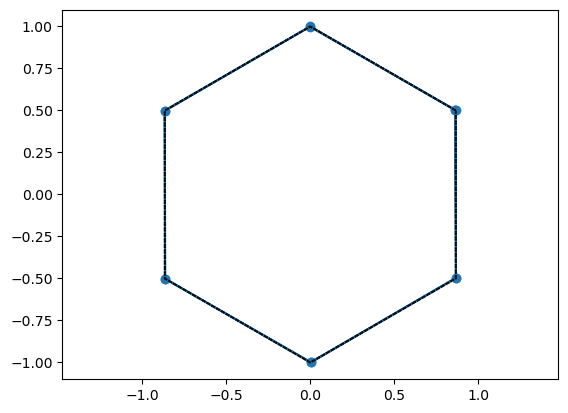

In [3]:
import matplotlib.pyplot as plt
plt.plot(uNum.real, uNum.imag, 'o-')
plt.axis("equal")

times = np.linspace(0, T, nSteps+1)
uExact = u0 * np.exp(lam*times)
plt.plot(uExact.real, uExact.imag, ':', c="k")
print("L_inf error : {:1.5f}".format(np.linalg.norm(uNum-uExact, ord=np.inf)))

While the error is not as small as the [collocation solution in tutorial 2](./02_rk.ipynb), this is still more accurate compared to the RK4 method in the same tutorial. In fact, SDC's accuracy depends on the number of **sweeps** performed within each steps; if we write the full **sweep update** (iteration) :

$$
u^{k+1} = u^{k} + P^{-1} \left[u_n - A u^{k}\right],
$$

we can see that **if it converges** to a fixed point solution $u^{\infty}$ (which we assume for now), then its is simply the solution of the all-at-once system as $u_n - A u^{\infty} = 0$.

And if we look at the structure of $P$ here :

In [4]:
print("P :")
print(P)

P :
[[1.-0.09276909j 0.+0.j         0.+0.j         0.+0.j        ]
 [0.-0.09276909j 1.-0.3360236j  0.+0.j         0.+0.j        ]
 [0.-0.09276909j 0.-0.3360236j  1.-0.39604236j 0.+0.j        ]
 [0.-0.09276909j 0.-0.3360236j  0.-0.39604236j 1.-0.22236249j]]


$\Rightarrow$ this is a lower triangular matrix, which means that we don't need to solve the system _all-at-once_, but we can solve it line by line as it is done for classical RK method (_c.f_ [tutorial 2](./02_rk.ipynb)).

However, this comes with some drawback : since it's an **iterative process**, one should do enough sweeps to retrieve a satisfying accuracy. To look deeper into it, we simplify the node solution update by
replacing in it $P$ and $A$ by their expression :

$$
u^{k+1} - \lambda\Delta{t}Q_\Delta u^{k+1} = u_n + \lambda\Delta{t}(Q-Q_\Delta)u^k.
$$

This update formula is more stable from a numerical perspective and simpler from an implementation perspective. 
So our SDC time-steppers becomes :

In [5]:
nSweeps = 4
for i in range(nSteps):

    uNodes = np.ones(nodes.size)*uNum[i]  # initial guess
    for k in range(nSweeps):
        # nodes solution update
        b = uNum[i] + lam*dt*(Q-QDelta) @ uNodes
        uNodes = np.linalg.solve(P, b)  

    uNum[i+1] = uNum[i] + lam*dt*weights.dot(uNodes)  # prolongation

Of course, some convenience functions are provided by `qmat` directly, so we compute the SDC solution with : 

In [6]:
from qmat.sdc import solveDahlquistSDC
uNum = solveDahlquistSDC(lam, u0, T, nSteps, nSweeps, Q, QDelta, weights)

and we observe of the solution evolves with each sweeps :

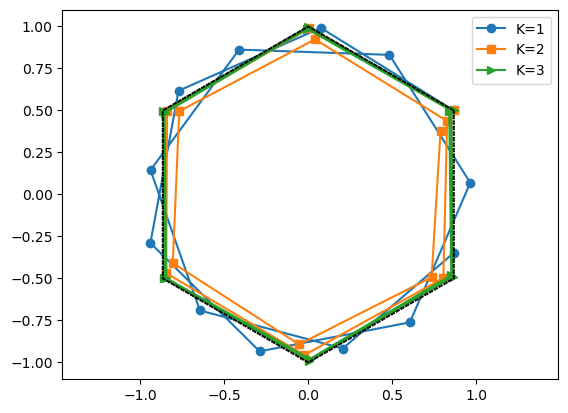

In [7]:
for nSweeps, sym in zip([1, 2, 3], ['o', 's', '>']):
    uNum = solveDahlquistSDC(lam, u0, T, nSteps, nSweeps, Q, QDelta, weights)
    plt.plot(uNum.real, uNum.imag, sym+'-', label=f"K={nSweeps}")
plt.axis("equal")
plt.legend()
plt.plot(uExact.real, uExact.imag, ':', c="k");

For the first sweep, the numerical solution is very far from the exact solution. 
And as expected, doing more sweeps corrects it toward the exact solution.

This can be illustrated more rigorously looking at the $L_\infty$ error :

In [8]:
from qmat.sdc import errorDahlquistSDC

for nSweeps in [1, 2, 3, 4, 5, 6, 8, 9]:
    err = errorDahlquistSDC(lam, u0, T, nSteps, nSweeps, Q, QDelta, weights)
    print(f"nSweeps={nSweeps}, err={err:1.5f}")

nSweeps=1, err=0.84538
nSweeps=2, err=0.14365
nSweeps=3, err=0.02750
nSweeps=4, err=0.00535
nSweeps=5, err=0.00106
nSweeps=6, err=0.00021
nSweeps=8, err=0.00002
nSweeps=9, err=0.00001


In particular, for the $Q_\Delta$ based on Backward Euler, it takes $K=9$ sweeps to reach a similar accuracy as this of the underlying collocation method (cf [tutorial 2](./02_rk.ipynb)).

The choice of $Q_\Delta$ for the preconditioner has actually a big impact on how fast SDC converges to the solution of the all-at-once system, hence the different $Q_\Delta$-generators provided by `qmat`.
For instance, using those _magical_ `MIN3` coefficients introduced in [tutorial 2](./03_qDelta.ipynb) ...

In [9]:
QDelta = QDELTA_GENERATORS["MIN3"](nNodes=coll.nNodes, nodeType=coll.nodeType, quadType=coll.quadType).getQDelta()
for nSweeps in [1, 2, 3, 4, 5, 6, 8, 9]:
    err = errorDahlquistSDC(lam, u0, T, nSteps, nSweeps, Q, QDelta, weights)
    print(f"nSweeps={nSweeps}, err={err:1.5f}")

nSweeps=1, err=1.62904
nSweeps=2, err=0.05860
nSweeps=3, err=0.00558
nSweeps=4, err=0.00036
nSweeps=5, err=0.00002
nSweeps=6, err=0.00001
nSweeps=8, err=0.00001
nSweeps=9, err=0.00001


... makes SDC converge way faster to the solution of the _all-at-once system_ !
However, evaluating the quality of a given $Q_\Delta$ for more complex problems
can be difficult as usually no exact solution is known beforehand to compute the error.

But SDC also provides a built-in indicator to estimate the error,
by [monitoring the residuals after each sweeps ...](./05_residuals.ipynb)